In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd
import os
import h5py
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Load embeddings and align classes

In [3]:
embeddings = h5py.File('embeddings.h5', 'r')

def printname(name):
    print(name)
embeddings.visit(printname)

irmas
irmas/openl3
irmas/openl3/features
irmas/openl3/keys
irmas/vggish
irmas/vggish/features
irmas/vggish/keys
openmic
openmic/openl3
openmic/openl3/features
openmic/openl3/keys
openmic/vggish
openmic/vggish/features
openmic/vggish/keys


In [4]:
with open('class-map-10.json', 'r') as f: # only consider 10 classes of Openmic dataset
    class_map = json.load(f)
    
class_map

{'cello': 3,
 'clarinet': 4,
 'flute': 7,
 'guitar': 8,
 'organ': 11,
 'piano': 12,
 'saxophone': 13,
 'trumpet': 16,
 'violin': 18,
 'voice': 19}

In [5]:
# use a dict to align the classes between Openmic dataset (key) and Irmas dataset (val)
class_align = {'cello': 'cel',
               'clarinet': 'cla',
               'flute': 'flu',
               'guitar': ['gac', 'gel'],
               'organ': 'org',
               'piano': 'pia',
               'saxophone': 'sax',
               'trumpet': 'tru',
               'violin': 'vio',
               'voice': 'voi'}

In [6]:
# use a Pandas DataFrame to record all results and save into a csv file later
result_all = pd.DataFrame({'instrument': [],
                          'train_set': [],
                          'test_set': [],
                          'precision': [],
                          'recall': [],
                          'f1-score': [],
                          'support': [],
                         })

# irmas->irmas

In [7]:
# irmas: openl3 embedding
feature = np.array(embeddings['irmas']['openl3']['features'])
keys_ori = np.array(embeddings['irmas']['openl3']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

(167625, 512) (167625,)
(6705,)


In [8]:
key_clip

array([b'001__[gel][dru][pop_roc]0829__1',
       b'001__[gel][dru][pop_roc]0829__2',
       b'001__[gel][dru][pop_roc]0829__3', ..., b'[voi][pop_roc]2548__1',
       b'[voi][pop_roc]2548__2', b'[voi][pop_roc]2548__3'], dtype=object)

In [9]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [10]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

In [11]:
# These loops go through all sample keys, and save their row numbers to either idx_train or idx_test
idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        # This should never happen, but better safe than sorry.
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
# cast the idx_* arrays to numpy structures
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [12]:
keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [13]:
# use the split indices to partition the features, labels, and masks
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

# print out the sliced shapes as a sanity check
print(X_train.shape)
print(X_test.shape)

(3910, 512)
(2795, 512)


In [14]:
train_set_name, test_set_name = 'irmas', 'irmas'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()   

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_train_inst = Y_true_train==instrument
    Y_true_test_inst = Y_true_test==instrument
    
    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100] }  
    scoring = 'f1'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train, Y_true_train_inst)

    # predict
    Y_pred_test_inst = clf.predict(X_test)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    #########################  record result of each split  ###############################
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support']]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       1.00      0.94      0.97      2765
        True       0.14      0.87      0.25        30

    accuracy                           0.94      2795
   macro avg       0.57      0.91      0.61      2795
weighted avg       0.99      0.94      0.96      2795

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       1.00      0.73      0.84      2744
        True       0.06      1.00      0.12        51

    accuracy                           0.73      2795
   macro avg       0.53      0.86      0.48      2795
weighted avg       0.98      0.73      0.83      2795

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.87      1.00      0.93      2388
        True       0.87      0.10      

In [15]:
# l2, cv5, f1, liblinear, cmax=10: 34.9
# l2, cv3, f1, liblinear, cmax=10: 35.1
# l2, cv3, f1, liblinear, cmax=100: 35.1
# l2, cv5, f1, liblinear, cmax=100: 34.8

# openmic->openmic

In [16]:
# openmic: openl3 embedding
feature = np.array(embeddings['openmic']['openl3']['features'])
keys = np.array(embeddings['openmic']['openl3']['keys'])
print(feature.shape, keys.shape)

key_clip = np.unique(keys)
key_clip.shape

(1900000, 512) (1900000,)


(20000,)

In [17]:
feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

key_clip = np.array([str(k, 'utf-8') for k in key_clip])
key_clip

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000,)


array(['000046_3840', '000135_483840', '000139_119040', ...,
       '155307_211200', '155310_372480', '155311_453120'], dtype='<U15')

In [18]:
# key-label map using the information from the dataset source
data_root = '/import/c4dm-datasets/openmic-2018/openmic-2018/'

np_load_old = np.load   # save np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True,**k)   # modify the default parameters of np.load

Ytrue = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_true']
Ymask = np.load(os.path.join(data_root, 'openmic-2018.npz'))['Y_mask']
sample_key = np.load(os.path.join(data_root, 'openmic-2018.npz'))['sample_key']

np.load = np_load_old   # restore np.load for future normal usage
del(np_load_old)

print(Ytrue.shape, Ymask.shape, sample_key.shape)

(20000, 20) (20000, 20) (20000,)


In [19]:
Y_true = []
Y_mask = []

for key in tqdm(key_clip):
    Y_true.append(Ytrue[sample_key==key])
    Y_mask.append(Ymask[sample_key==key])
    
Y_true = np.squeeze(np.array(Y_true))
Y_mask = np.squeeze(np.array(Y_mask))

X = feature_clip
del(feature_clip)

print(X.shape, Y_true.shape, Y_mask.shape)

  0%|          | 0/20000 [00:00<?, ?it/s]

(20000, 512) (20000, 20) (20000, 20)


In [20]:
# train-test split
split_train = pd.read_csv('openmic2018_train.csv', header=None, squeeze=True)
split_test = pd.read_csv('openmic2018_test.csv', header=None, squeeze=True)

print('# Train: {},  # Test: {}'.format(len(split_train), len(split_test)))

train_set = set(split_train)
test_set = set(split_test)

# Train: 14915,  # Test: 5085


In [21]:
idx_train, idx_test = [], []

for idx, n in enumerate(key_clip):
    if n in train_set:
        idx_train.append(idx)
    elif n in test_set:
        idx_test.append(idx)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[n]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [22]:
X_train = X[idx_train]
X_test = X[idx_test]

Y_true_train = Y_true[idx_train]
Y_true_test = Y_true[idx_test]

Y_mask_train = Y_mask[idx_train]
Y_mask_test = Y_mask[idx_test]

print(X_train.shape); print(X_test.shape)

(14915, 512)
(5085, 512)


In [23]:
# This part of the code follows the baseline model for instrument recognition on the openmic dataset:
# https://github.com/cosmir/openmic-2018/blob/master/examples/modeling-baseline.ipynb
train_set_name, test_set_name = 'openmic', 'openmic'

# use a dictionary to include the classifier for each instrument trained on the dataset based on the embedding
globals()['models_'+train_set_name] = dict()   

# We'll iterate over all istrument classes, and fit a model for each one
# After training, we'll print a classification report for each instrument
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations
    # This is what the mask arrays are for
    train_inst = Y_mask_train[:, inst_num]
    test_inst = Y_mask_test[:, inst_num]
    
    # Here, we're using the Y_mask_train array to slice out only the training examples
    # for which we have annotations for the given class
    X_train_inst = X_train[train_inst]
    
    # Again, we slice the labels to the annotated examples
    # We thresold the label likelihoods at 0.5 to get binary labels
    Y_true_train_inst = Y_true_train[train_inst, inst_num] >= 0.5
    
    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # initialize and a logistic regression model
    LRmodel = LogisticRegression(random_state=0, penalty='l2', solver='liblinear', class_weight='balanced')
    
    # hyperparameter tunning for logistic regression model
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10] }  
    scoring = 'f1'; cv = 3
    clf =  GridSearchCV(LRmodel, param_grid=param_grid, cv=cv, scoring=scoring)    
    
    # fit the model
    clf.fit(X_train_inst, Y_true_train_inst)

    # predict
    Y_pred_test_inst = clf.predict(X_test_inst)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    # store the classifier in the model dictionary
    globals()['models_'+train_set_name][instrument] = clf
    
    #########################  record result of each split  ###############################
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support']]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.84      0.79      0.81       259
        True       0.78      0.82      0.80       226

    accuracy                           0.81       485
   macro avg       0.81      0.81      0.81       485
weighted avg       0.81      0.81      0.81       485

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.89      0.60      0.72       503
        True       0.33      0.73      0.46       137

    accuracy                           0.63       640
   macro avg       0.61      0.67      0.59       640
weighted avg       0.77      0.63      0.66       640

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.85      0.60      0.71       387
        True       0.47      0.77      

# irmas->openmic

In [24]:
train_set_name, test_set_name = 'irmas', 'openmic' 

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # Map the instrument name to its column number
    inst_num = class_map[instrument]
    
    # First, sub-sample the data: we need to select down to the data for which we have annotations 
    # This is what the mask arrays are for
    test_inst = Y_mask_test[:, inst_num]

    # Repeat the above slicing and dicing but for the test set
    X_test_inst = X_test[test_inst]
    Y_true_test_inst = Y_true_test[test_inst, inst_num] >= 0.5

    # Finally, we'll evaluate the classifier
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test_inst)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    #########################  record result of each split  ###############################
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support']]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       0.55      0.93      0.69       259
        True       0.59      0.12      0.20       226

    accuracy                           0.55       485
   macro avg       0.57      0.52      0.44       485
weighted avg       0.57      0.55      0.46       485

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       0.80      0.91      0.85       503
        True       0.30      0.14      0.19       137

    accuracy                           0.75       640
   macro avg       0.55      0.52      0.52       640
weighted avg       0.69      0.75      0.71       640

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.69      1.00      0.82       387
        True       1.00      0.01      

# openmic->irmas

In [25]:
# irmas: openl3 embedding
feature = np.array(embeddings['irmas']['openl3']['features'])
keys_ori = np.array(embeddings['irmas']['openl3']['keys'])
print(feature.shape, keys_ori.shape)

key_clip = np.unique(keys_ori)
print(key_clip.shape)

feature_clip = []

for key in tqdm(key_clip):
    feature_clip.append(np.mean(feature[keys_ori[:]==key,:],axis=0))
    
feature_clip = np.array(feature_clip)
print(feature_clip.shape, key_clip.shape)

(167625, 512) (167625,)
(6705,)


  0%|          | 0/6705 [00:00<?, ?it/s]

(6705, 512) (6705,)


In [26]:
key_train = list(pd.read_csv('irmas_train.csv', header=None, squeeze=True))
key_test = list(pd.read_csv('irmas_test.csv', header=None, squeeze=True))

idx_train, idx_test = [], []

for k in range(len(key_clip)):
    if str(key_clip[k]) in key_train:
        idx_train.append(k)
    elif str(key_clip[k]) in key_test:
        idx_test.append(k)
    else:
        raise RuntimeError('Unknown sample key={}! Abort!'.format(key_clip[k]))
        
idx_train = np.asarray(idx_train)
idx_test = np.asarray(idx_test)

In [27]:
keys = np.array([str(k, 'utf-8') for k in key_clip])
keys = [key[key.index('[')+1:key.index(']')] for key in keys]

for key in class_align:
    keys = [key if x in class_align[key] else x for x in keys]
    
keys = np.array(keys)
np.unique(keys)

array(['cello', 'clarinet', 'flute', 'guitar', 'organ', 'piano',
       'saxophone', 'trumpet', 'violin', 'voice'], dtype='<U9')

In [28]:
X_train = feature_clip[idx_train,:]
X_test = feature_clip[idx_test]

Y_true_train = keys[idx_train]
Y_true_test = keys[idx_test]

print(X_train.shape)
print(X_test.shape)

(3910, 512)
(2795, 512)


In [29]:
train_set_name, test_set_name = 'openmic', 'irmas'

# iterate over all istrument classes, and fit a model for each one
for instrument in class_align:
    
    # get the training and testing labels for each instrument
    Y_true_test_inst = Y_true_test==instrument

    # evaluate the classifier
    Y_pred_test_inst =  globals()['models_'+train_set_name][instrument].predict(X_test)
    
    # print result for each instrument
    print('-' * 52); print(instrument); print('\tTEST')
    print(classification_report(Y_true_test_inst, Y_pred_test_inst))
    
    #########################  record result of each split  ###############################
    report = pd.DataFrame(classification_report(Y_true_test_inst, Y_pred_test_inst, output_dict=True))['True']
    result_inst = [instrument, train_set_name, test_set_name, report['precision'], report['recall'],
                   report['f1-score'], report['support']]   
    result_all = result_all.append(pd.DataFrame(np.expand_dims(np.array(result_inst), axis=0), 
                                                columns=result_all.columns), ignore_index=True)

----------------------------------------------------
cello
	TEST
              precision    recall  f1-score   support

       False       1.00      0.69      0.81      2765
        True       0.03      0.97      0.06        30

    accuracy                           0.69      2795
   macro avg       0.52      0.83      0.44      2795
weighted avg       0.99      0.69      0.81      2795

----------------------------------------------------
clarinet
	TEST
              precision    recall  f1-score   support

       False       1.00      0.31      0.48      2744
        True       0.03      1.00      0.05        51

    accuracy                           0.32      2795
   macro avg       0.51      0.66      0.26      2795
weighted avg       0.98      0.32      0.47      2795

----------------------------------------------------
flute
	TEST
              precision    recall  f1-score   support

       False       0.94      0.57      0.71      2388
        True       0.24      0.81      

# Plot result for each instrument

In [30]:
# save all result into a csv file
result_all.to_csv('OpenL3_crossdataset_result.csv', index=False)

In [31]:
# check the PRF averaged over all instruments for each case:

train_irmas = result_all[result_all['train_set']=='irmas']
train_openmic = result_all[result_all['train_set']=='openmic']

irmas_irmas = train_irmas[train_irmas['test_set']=='irmas']
irmas_openmic = train_irmas[train_irmas['test_set']=='openmic']
openmic_openmic = train_openmic[train_openmic['test_set']=='openmic']
openmic_irmas = train_openmic[train_openmic['test_set']=='irmas']

print('PRF of Vggish averaged over all instruments for each case:')
print('openmic->openmic:{}'.format(list(openmic_openmic[['precision', 'recall', 'f1-score']].astype(float).mean(axis=0).round(2))))
print('irmas->openmic:{}'.format(list(irmas_openmic[['precision', 'recall', 'f1-score']].astype(float).mean(axis=0).round(2))))
print('irmas->irmas:{}'.format(list(irmas_irmas[['precision', 'recall', 'f1-score']].astype(float).mean(axis=0).round(2))))
print('openmic->irmas:{}'.format(list(openmic_irmas[['precision', 'recall', 'f1-score']].astype(float).mean(axis=0).round(2))))

PRF of Vggish averaged over all instruments for each case:
openmic->openmic:[0.74, 0.84, 0.78]
irmas->openmic:[0.75, 0.34, 0.39]
irmas->irmas:[0.48, 0.66, 0.35]
openmic->irmas:[0.19, 0.84, 0.29]


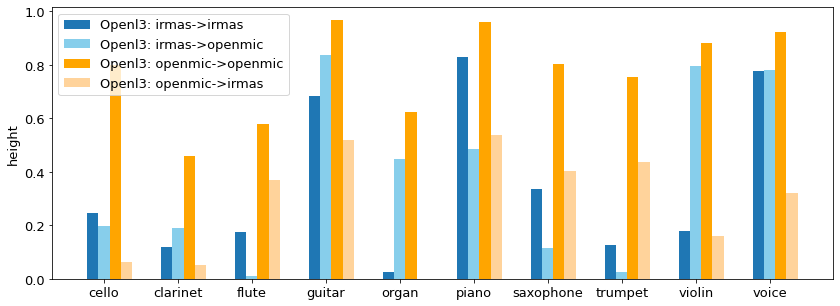

In [32]:
plt.rcParams.update({'font.size':13})
plt.figure(figsize=(14,5))
 
barWidth = 0.15  # width of the bars

# Set bars
bars1 = [float(irmas_irmas[irmas_irmas['instrument']==inst]['f1-score'].values[0]) for inst in class_align]
bars2 = [float(irmas_openmic[irmas_openmic['instrument']==inst]['f1-score'].values[0]) for inst in class_align]
bars3 = [float(openmic_openmic[openmic_openmic['instrument']==inst]['f1-score'].values[0]) for inst in class_align]
bars4 = [float(openmic_irmas[openmic_irmas['instrument']==inst]['f1-score'].values[0]) for inst in class_align]

# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + 2*barWidth for x in r1]
r4 = [x + 3*barWidth for x in r1]
 
# Create bars
plt.bar(r1, bars1, width = barWidth, capsize=7, label='Openl3: irmas->irmas')
plt.bar(r2, bars2, width = barWidth, color='skyblue', capsize=7, label='Openl3: irmas->openmic')
plt.bar(r3, bars3, width = barWidth, color='#FFA500', capsize=7, label='Openl3: openmic->openmic')
plt.bar(r4, bars4, width = barWidth, color='#FFD39B', capsize=7, label='Openl3: openmic->irmas')
 
plt.xticks([r + barWidth for r in range(len(bars1))], [inst for inst in class_align])
plt.ylabel('height'); plt.legend()